In [1]:
import tensorflow as tf
import numpy as np
import cv2

import matplotlib.pyplot as plt

from cell_division.nets.transfer_learning import CNN
from auxiliary.data.dataset_cell import CellDataset
from auxiliary import values as v
from auxiliary.utils import visualizer as vis
from auxiliary.utils.colors import bcolors as bc

from sklearn.metrics import classification_report, confusion_matrix
from cell_division.layers.custom_layers import (
    ExtendedLSEPooling,
    extended_w_cel_loss
)

from cell_division.nets.cam import overlay_heatmap, CAM

# GPU config
from auxiliary.gpu.gpu_tf import (
    increase_gpu_memory, 
    set_gpu_allocator
)
plt.style.use('default')

import os
import warnings

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')


increase_gpu_memory()
set_gpu_allocator()


Data

In [2]:
img_dir = v.data_path + 'CellDivision/images_nuclei/'
label_train_dir = v.data_path + 'CellDivision/undersampled/train.csv'
label_test_dir = v.data_path + 'CellDivision/undersampled/test.csv'
label_val_dir = v.data_path + 'CellDivision/undersampled/val.csv'

INPUT_SHAPE = (100, 100, 3)
BATCH_SIZE = 32

In [3]:
train_generator = CellDataset(
    img_dir, 
    label_train_dir,
    batch_size=BATCH_SIZE,
    resize=INPUT_SHAPE[:2]
)

val_generator = CellDataset(
    img_dir, 
    label_val_dir,
    batch_size=BATCH_SIZE,
    resize=INPUT_SHAPE[:2]
)

test_generator = CellDataset(
    img_dir, 
    label_test_dir,
    batch_size=BATCH_SIZE,
    resize=INPUT_SHAPE[:2]
)

Training

In [4]:
model = CNN(
    base=tf.keras.applications.VGG16,
    input_shape=INPUT_SHAPE,
    n_classes=3
)
model.build_top(activation='softmax', b_type='CAM', pooling=ExtendedLSEPooling)
model.compile(
    lr=.001,
    loss=extended_w_cel_loss()
)

In [5]:
# model.fit(
#     train_generator,
#     val_generator,
#     epochs=100,
#     verbose=2,
#     batch_size=BATCH_SIZE
# )
# 
# model.model.save('../models/cellular_division_models/vgg16_nuclei_under.h5')

In [6]:
model.load('../models/cellular_division_models/vgg16_nuclei_under.h5')

Testing

In [7]:
results = model.model.evaluate(test_generator, verbose=1)

4/4 [==============================] - 4s 668ms/step - loss: 0.6904 - auc: 0.9435


In [8]:
pred = model.model.predict(test_generator).round().astype(int)

print(
    classification_report(
        test_generator.img_labels, [test_generator.oh2class(p) for p in pred], 
        target_names=test_generator.CLASS_NAMES,
        zero_division=0
    )
)

                    precision    recall  f1-score   support

Prophase/Metaphase       0.89      0.81      0.85        42
Anaphase/Telophase       0.82      0.86      0.84        42
        Interphase       0.87      0.91      0.89        43

          accuracy                           0.86       127
         macro avg       0.86      0.86      0.86       127
      weighted avg       0.86      0.86      0.86       127



<Figure size 1200x1200 with 0 Axes>

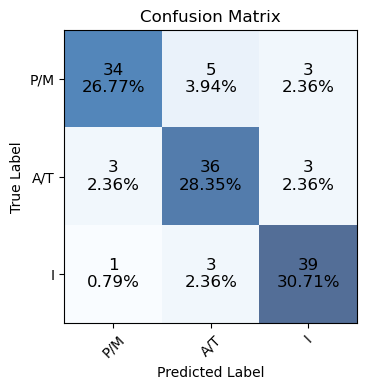

In [9]:
cf_matrix = confusion_matrix(
    test_generator.img_labels, [test_generator.oh2class(p) for p in pred]
)

plt.figure(figsize=(12, 12))
vis.plot_confusion_matrix(cf_matrix)

Grad-CAM

In [10]:
test_generator = CellDataset(
    img_dir, 
    label_test_dir, 
    batch_size=1, 
    resize=INPUT_SHAPE[:2]
)

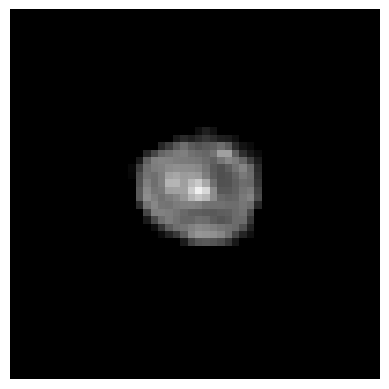

In [11]:
img_idx = 25 # 87 # 44 # 40 # 0  # 98  # 25
test_img_tf = test_generator[img_idx][0]
test_img = test_img_tf.numpy().astype(np.float32)
test_img = test_img.reshape(INPUT_SHAPE)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

plt.imshow(test_img); plt.axis('off')
plt.show()

Real label: Interphase
Predicted label: Interphase


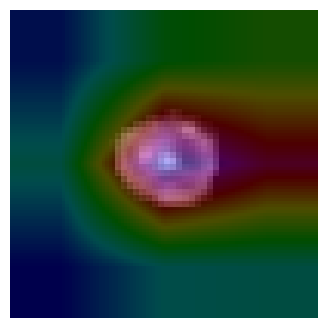

In [12]:
cam = CAM(model.model)
pred = model.model.predict(test_img_tf)
print(f'Real label: {test_generator.oh2name(test_generator[img_idx][1])}')
print(f'Predicted label: {test_generator.oh2name(pred)}')

pred_idx = np.argmax(pred)
heatmap = cam.compute_heatmap(test_img_tf, class_idx=pred_idx)

plt.figure(figsize=(4, 4))
plt.imshow(overlay_heatmap(test_img, heatmap, alpha=.7, colormap=cv2.COLORMAP_HSV))
plt.axis('off')
plt.show()

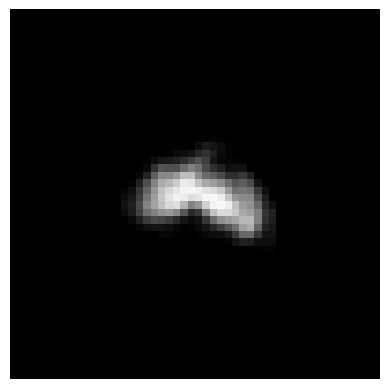

In [13]:
img_idx = 35 # 87 # 44 # 40 # 0  # 98  # 25
test_img_tf = test_generator[img_idx][0]
test_img = test_img_tf.numpy().astype(np.float32)
test_img = test_img.reshape(INPUT_SHAPE)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

plt.imshow(test_img); plt.axis('off')
plt.show()

Real label: Prophase/Metaphase
Predicted label: Prophase/Metaphase


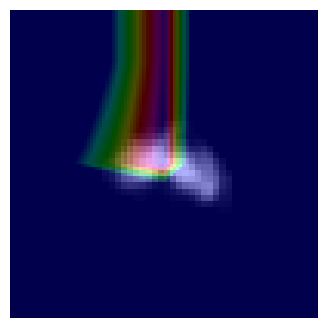

In [14]:
cam = CAM(model.model)
pred = model.model.predict(test_img_tf)
print(f'Real label: {test_generator.oh2name(test_generator[img_idx][1])}')
print(f'Predicted label: {test_generator.oh2name(pred)}')

pred_idx = np.argmax(pred)
heatmap = cam.compute_heatmap(test_img_tf, class_idx=pred_idx)

plt.figure(figsize=(4, 4))
plt.imshow(overlay_heatmap(test_img, heatmap, alpha=.7, colormap=cv2.COLORMAP_HSV))
plt.axis('off')
plt.show()

Model calibration

In [22]:
from cell_division.calibration_assessment import (
    plot_multilabel_reliability_diagram,
    plot_calibration_map,
    plot_learned_calibration_map,
    compute_ece,
    compute_multilabel_brier
)


def compute_calibrations(model, X_calib, y_calib, X_test, y_test, methods):
    
    results = {
        'method': [],
        'test_results': [],
        'ece': [],
        'brier': []
    }
    
    for method in methods:
        model.calibrate(X_calib, y_calib, method=method)
        calibrated_pred = model.calibrated_model.predict(X_test)

        print(model.calibrated_model.summary())

        print(f'{bc.OKGREEN}Calibration method:{bc.ENDC} {method}')
        print(f'\t{bc.OKBLUE}Weights:{bc.ENDC}')
        print(model.calibrated_model.weights[-1])
        
        print(f'\t{bc.OKBLUE}Test results:{bc.ENDC}')
        res = model.calibrated_model.evaluate(test_generator, verbose=1)
        print(res)
        
        print(f'\t{bc.OKBLUE}Test classification report:{bc.ENDC}')
        print(
            classification_report(
                test_generator.img_labels, 
                [test_generator.oh2class(p) for p in calibrated_pred], target_names=test_generator.CLASS_NAMES, zero_division=0
            )
        )
        
        ece = compute_ece(y_test, calibrated_pred)
        print(f'\t{bc.OKBLUE}Expected Calibration Error:{bc.ENDC} {ece:.4f}')
        
        brier = compute_multilabel_brier(y_test, calibrated_pred)
        print(f'\t{bc.OKBLUE}Multilabel Brier score:{bc.ENDC} {brier:.4f}')
        
        plt.figure(figsize=(12, 12))
        plt.subplot(2, 2, 1)
        
        cf_matrix = confusion_matrix(
            test_generator.img_labels, 
            [test_generator.oh2class(p) for p in calibrated_pred]
        )
        vis.plot_confusion_matrix(cf_matrix, sub_index=1, nrows=2, ncols=2)
        
        plt.subplot(2, 2, 2)
        plot_multilabel_reliability_diagram(
            y_test, calibrated_pred, test_generator.CLASS_NAMES,
            sub_index=2, nrows=2, ncols=2
        )
        
        plt.subplot(2, 2, 3)
        plot_calibration_map(
            model.model, model.calibrated_model,
            X_test, test_generator.img_labels, title='Calibration map',
            sub_index=3, nrows=2, ncols=2
        )
        
        plt.subplot(2, 2, 4)
        plot_learned_calibration_map(
            model.calibrated_model,
            'Learned calibration map',
            sub_index=4, nrows=2, ncols=2
        )
        
        plt.show()
        
        results['method'].append(method)
        results['test_results'].append(res)
        results['ece'].append(ece)
        results['brier'].append(brier)
        model.calibrated_model.save(
            f'../models/cellular_division_models/vgg16_nuclei_under_calibrated_{method}.h5'
        )
        
    return results
        
        

In [23]:
calibration_generator = CellDataset(
    img_dir, 
    label_val_dir,
    batch_size=1,
    resize=INPUT_SHAPE[:2]
)

X_calib, y_calib = calibration_generator.get_all()
print(X_calib.shape, y_calib.shape)

X_test, y_test = test_generator.get_all()
print(X_test.shape, y_test.shape)

(102, 100, 100, 3) (102, 3)
(127, 100, 100, 3) (127, 3)


Trainable variables:  1
temperature:0
Epoch 1/100
4/4 [==============================] - 1s 37ms/step - loss: 1.0823 - auc: 0.9209 - lr: 0.0500
Epoch 2/100
4/4 [==============================] - 0s 24ms/step - loss: 1.0150 - auc: 0.9090 - lr: 0.0500
Epoch 3/100
4/4 [==============================] - 0s 24ms/step - loss: 0.9448 - auc: 0.9103 - lr: 0.0500
Epoch 4/100
4/4 [==============================] - 0s 30ms/step - loss: 0.7589 - auc: 0.9241 - lr: 0.0500
Epoch 5/100
4/4 [==============================] - 0s 32ms/step - loss: 0.7509 - auc: 0.9326 - lr: 0.0500
Epoch 6/100
4/4 [==============================] - 0s 33ms/step - loss: 0.6985 - auc: 0.9343 - lr: 0.0500
Epoch 7/100
4/4 [==============================] - ETA: 0s - loss: 0.7532 - auc: 0.9249
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.005000000074505806.
4/4 [==============================] - 0s 21ms/step - loss: 0.7532 - auc: 0.9249 - lr: 0.0500
Epoch 8/100
4/4 [==============================] - 0s 21ms/step - los

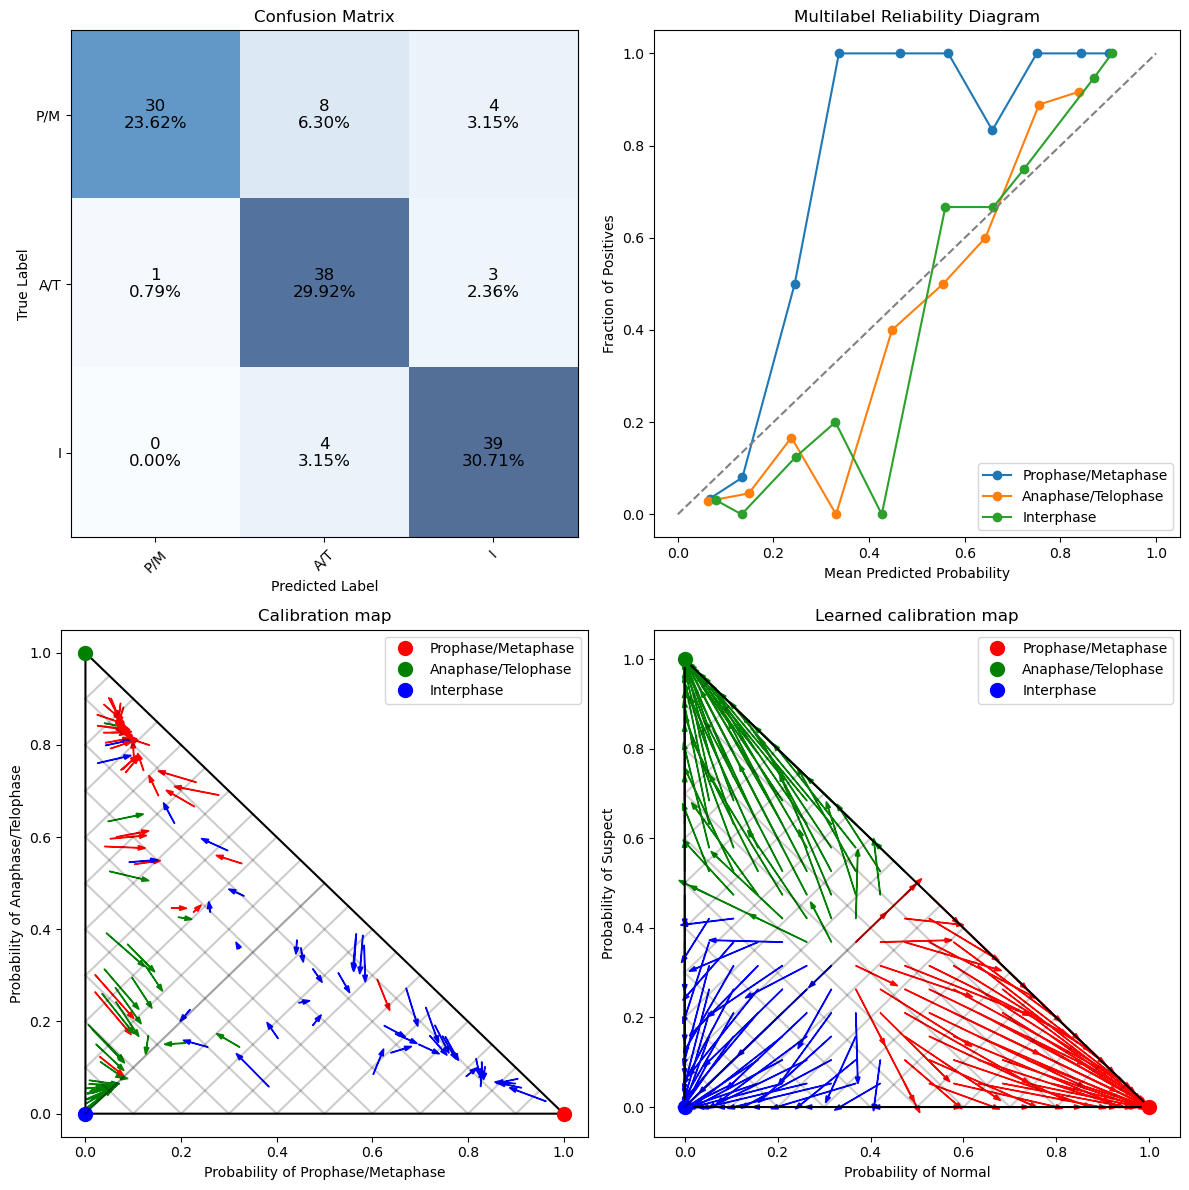

Trainable variables:  2
scale:0
bias:0
Epoch 1/100
4/4 [==============================] - 1s 42ms/step - loss: 1.0516 - auc: 0.9247 - lr: 0.0500
Epoch 2/100
4/4 [==============================] - 0s 24ms/step - loss: 1.0393 - auc: 0.9026 - lr: 0.0500
Epoch 3/100
4/4 [==============================] - 0s 22ms/step - loss: 0.9820 - auc: 0.9173 - lr: 0.0500
Epoch 4/100
4/4 [==============================] - 0s 35ms/step - loss: 0.9042 - auc: 0.9294 - lr: 0.0500
Epoch 5/100
4/4 [==============================] - 0s 21ms/step - loss: 0.8531 - auc: 0.9287 - lr: 0.0500
Epoch 6/100
4/4 [==============================] - 0s 21ms/step - loss: 0.8407 - auc: 0.9146 - lr: 0.0500
Epoch 7/100
3/4 [=====================>........] - ETA: 0s - loss: 0.8931 - auc: 0.9143
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.005000000074505806.
4/4 [==============================] - 0s 23ms/step - loss: 0.8637 - auc: 0.9219 - lr: 0.0500
Epoch 8/100
4/4 [==============================] - 0s 22ms/step - lo

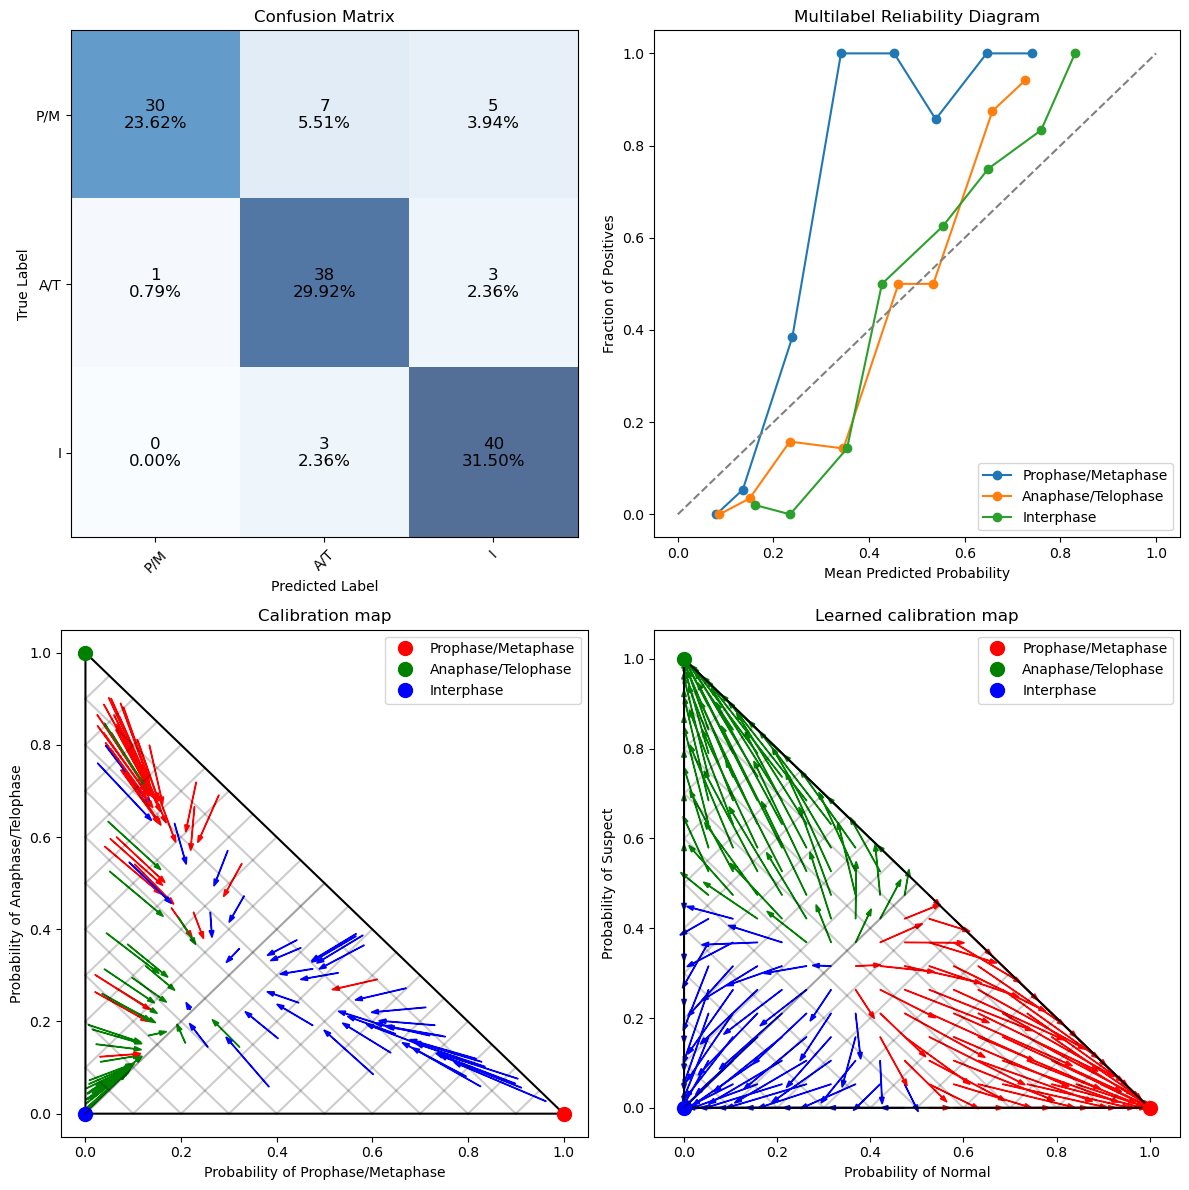

Trainable variables:  2
W:0
b:0
Epoch 1/100
4/4 [==============================] - 1s 36ms/step - loss: 1.1289 - auc: 0.8843 - lr: 0.0500
Epoch 2/100
4/4 [==============================] - 0s 32ms/step - loss: 0.8786 - auc: 0.9514 - lr: 0.0500
Epoch 3/100
4/4 [==============================] - 0s 21ms/step - loss: 0.9018 - auc: 0.9164 - lr: 0.0500
Epoch 4/100
4/4 [==============================] - 0s 22ms/step - loss: 0.9130 - auc: 0.8948 - lr: 0.0500
Epoch 5/100
4/4 [==============================] - 0s 22ms/step - loss: 0.8482 - auc: 0.9183 - lr: 0.0500
Epoch 6/100
4/4 [==============================] - ETA: 0s - loss: 0.7096 - auc: 0.9410
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.005000000074505806.
4/4 [==============================] - 0s 22ms/step - loss: 0.7096 - auc: 0.9410 - lr: 0.0500
Epoch 7/100
4/4 [==============================] - 0s 22ms/step - loss: 0.7871 - auc: 0.9021 - lr: 0.0050
Epoch 8/100
4/4 [==============================] - 0s 24ms/step - loss: 0.6

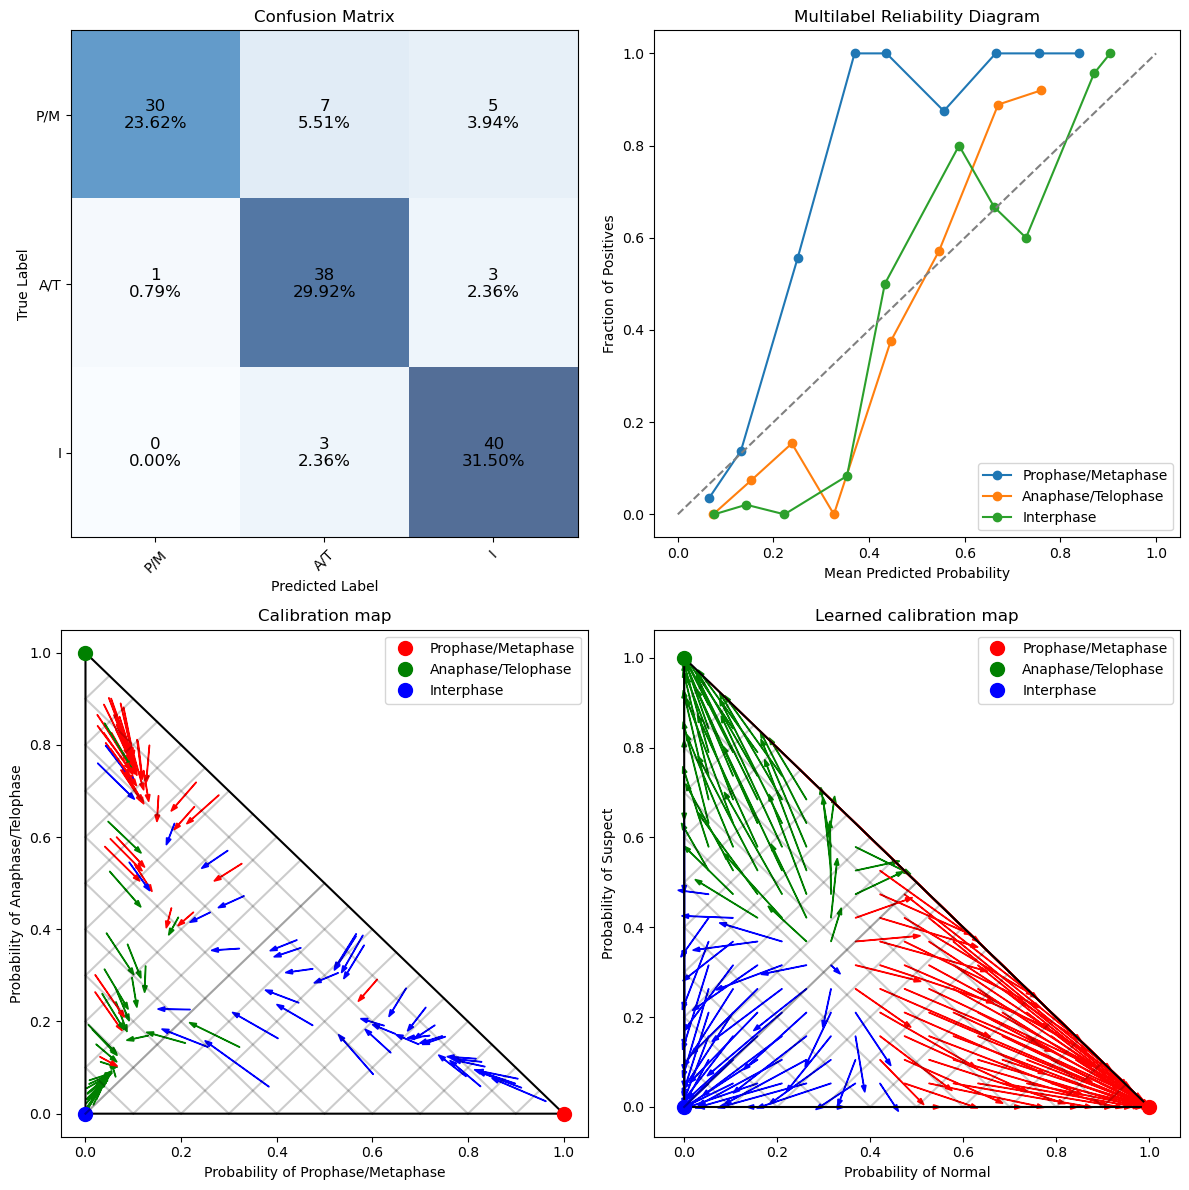

Trainable variables:  2
A:0
b:0
Epoch 1/100
4/4 [==============================] - 1s 37ms/step - loss: 1.0381 - auc: 0.9226 - lr: 0.0500
Epoch 2/100
4/4 [==============================] - 0s 32ms/step - loss: 0.9083 - auc: 0.9406 - lr: 0.0500
Epoch 3/100
4/4 [==============================] - 0s 21ms/step - loss: 0.8852 - auc: 0.9223 - lr: 0.0500
Epoch 4/100
4/4 [==============================] - 0s 22ms/step - loss: 0.8078 - auc: 0.9270 - lr: 0.0500
Epoch 5/100
4/4 [==============================] - 0s 22ms/step - loss: 0.7812 - auc: 0.9074 - lr: 0.0500
Epoch 6/100
4/4 [==============================] - 0s 23ms/step - loss: 0.8109 - auc: 0.9105 - lr: 0.0500
Epoch 7/100
4/4 [==============================] - 0s 23ms/step - loss: 0.8186 - auc: 0.9036 - lr: 0.0500
Epoch 8/100
4/4 [==============================] - 0s 23ms/step - loss: 0.7485 - auc: 0.9276 - lr: 0.0500
Epoch 9/100
4/4 [==============================] - 0s 22ms/step - loss: 0.7323 - auc: 0.9270 - lr: 0.0500
Epoch 10/100
4

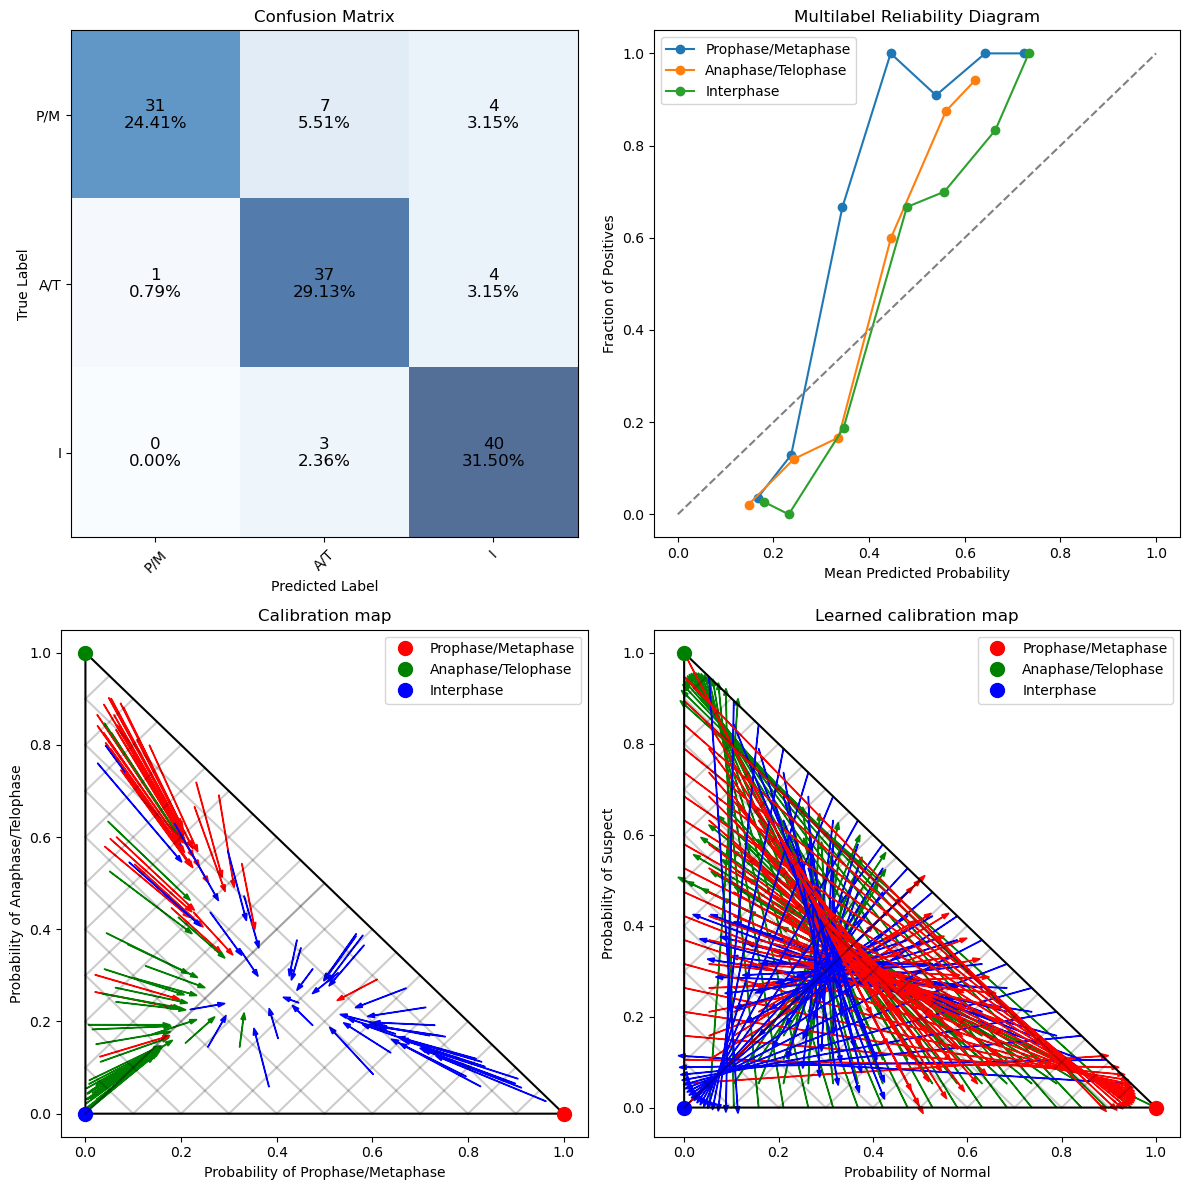

In [24]:
results = compute_calibrations(
    model, X_calib, y_calib, X_test, y_test, 
    ['temperature', 'vector', 'matrix', 'dirichlet']
)

In [25]:
import pandas as pd
pd.DataFrame(results)

,method,test_results,ece,brier
0,temperature,"[0.3024340867996216, 0.9542608261108398]",0.116870,0.086672
1,vector,"[0.3535713851451874, 0.9535573124885559]",0.200869,0.102310
2,matrix,"[0.3276796340942383, 0.954104483127594]",0.150585,0.094978
3,dirichlet,"[0.38837289810180664, 0.9556418061256409]",0.266150,0.113528
